# Assignment
In this homework, you are invited to solve an image classification problem to learn the behaviour of a racing car in a Gym environment [1].

The dataset (divided into training and test sets) contains 96x96 color images labelled with one out of the 5 actions available for the control of the car.

The dataset is provided as sets of images organized in folders labelled with the id of the action.  
https://drive.google.com/drive/folders/1bNL8icEqHNswHJfmhPsEcoxHy2zonAGd

Requirements on methodology and results:
- define your own model based on CNN (do not use pre-defined architectures or pre-trained models)
- solve the problem using 2 different approaches. By approaches, we mean architectures, optimizers, regularizations, preprocessing, etc., not just different values of the hyperparameters.
- report analysis of fundamental metrics, such as accuracy, f1, precision, and recall. Screenshoots of the output of some model is not sufficient. You must elaborate the results providing better visualizations and specific comments.
- conduct an analysis of at least one hyperparameter in relation to the chosen metrics.

In practice, you have to define two different approaches, train them with different hyperparameters, compare them (performance vs hyperparameter), visualize the results in proper forms (figures, tables), and discuss the results.
Any software library can be used, including Python (tensorflow or pytorch), MATLAB, etc.

The output of the assignment should be:
1) A PDF report (no other format is accepted) of about 10 pages, with your name and matricola code) describing the implemented solution: data pre-processing (if any), the exact model (with all the layers) that has been designed, the chosen optimizer, hyperparameter tuning, description of the evaluation method, comparative results using appropriate metrics, including training time, and discussion about the results. Conclusions should discuss the comparative results.
2) A ZIP file with the code you used in the project (not including the dataset)
3) [optional] a video (or a link to a video) showing the execution of the learned function as the policy driving the racing car on some tracks in the Gym environment (see the snippet of code in the dataset folder).

Submit the files through this assignment (other submission methods, such as e-mail, will not be accepted). Make sure to turn the assignment in, otherwise it will not reach the teachers.
NOTE: do not put the PDF report into the ZIP file!!!

This assignment must be individual (i.e., one submission for each student) and original (i.e., not equal or too similar to other works either from other students in this class or from other sources). Evaluation will be based on the appropriateness and correctness of the described solution, regardless of the numeric results (as long as they are reasonable).

Deadline: 14/1/2024 11:59 PM CET

[1] https://gymnasium.farama.org/environments/box2d/car_racing/

# Dataset

### Data import

Using some for cycles, the training and validation sets are loaded from the local drive.

In [1]:
import os
import numpy as np
import cv2

# train set
train_path = './dataset/train'
X_train_raw, y_train = [], np.array([], dtype=int)

for folder_name in os.listdir(train_path):
    action = int(folder_name)
    folder_path = os.path.join(train_path, folder_name)

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        obs = cv2.imread(image_path, cv2.IMREAD_COLOR)
        obs = cv2.cvtColor(obs, cv2.COLOR_BGR2RGB)

        X_train_raw.append(obs)
        y_train = np.append(y_train, action)
X_train_raw = np.array(X_train_raw)

train_len = X_train_raw.shape[0]
obs_shape = X_train_raw[0].shape
print(f'Train set: {train_len} images of shape {obs_shape}')

# validation set
val_path = './dataset/test'
X_val_raw, y_val = [], np.array([], dtype=int)

for folder_name in os.listdir(val_path):
    action = int(folder_name)
    folder_path = os.path.join(val_path, folder_name)

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        obs = cv2.imread(image_path, cv2.IMREAD_COLOR)
        obs = cv2.cvtColor(obs, cv2.COLOR_BGR2RGB)

        X_val_raw.append(obs)
        y_val = np.append(y_val, action)
X_val_raw = np.array(X_val_raw)

val_len = X_val_raw.shape[0]
print(f'Validation set: {val_len} images of shape {obs_shape}')

Train set: 6369 images of shape (96, 96, 3)
Validation set: 2749 images of shape (96, 96, 3)


Here's a random sample of the dataset.

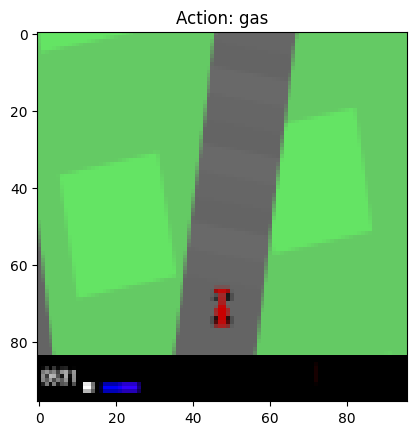

In [2]:
import matplotlib.pyplot as plt

action_names = ['do nothing', 'steer left', 'steer right', 'gas', 'brake']
actions = np.arange(len(action_names))

X_raw, y = np.concatenate((X_train_raw, X_val_raw),
                          0), np.concatenate((y_train, y_val))

j = np.random.randint(0, train_len+val_len-1)
plt.imshow(X_raw[j])
plt.title(f'Action: {action_names[y[j]]}')
plt.show()

### Class analysis

Analyze the dataset by evaluating the size of each class.

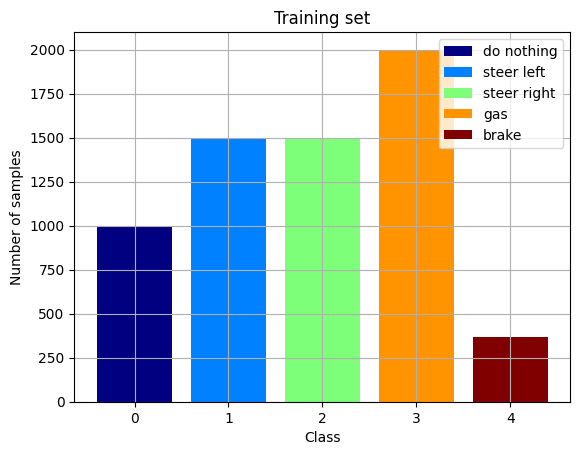

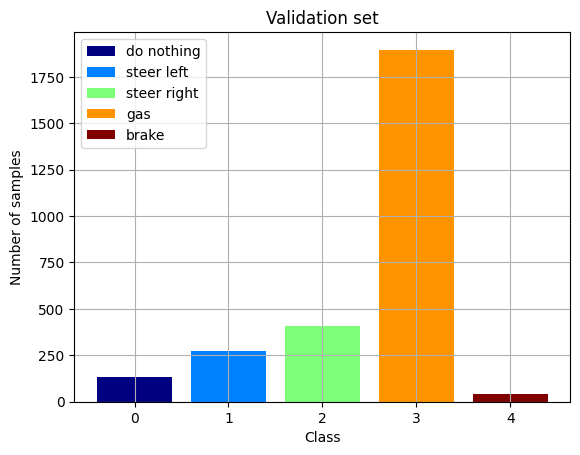

In [3]:
colors = plt.cm.jet(np.linspace(0, 1, actions.shape[0]))


def plot_class_sizes(y, title):
    barplot = plt.bar(actions, np.bincount(
        y), label=action_names, color=colors)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.legend()
    plt.grid()
    plt.show()


plot_class_sizes(y_train, 'Training set')
plot_class_sizes(y_val, 'Validation set')

### Image pre-processing


In order to delete unnecessary parts of the observations and enhance the important ones:
- make the grass color uniform;
- enhance the saturation;
- convert the colors to greyscale;
- hide the reward indicator.

In [4]:
def mask_grass(img_raw):
    img = np.copy(img_raw)
    red, green, blue = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    mask = (red == 100) & np.logical_and(
        green >= 200, green <= 230) & (blue == 100)
    img[:, :, :][mask] = [100, 255, 100]
    return img


def preprocess(img_raw):
    img = np.copy(img_raw)
    img = mask_grass(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img[:, :, 1] = 255
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img[85:, 0:12] = 0
    # img[85:, 17:] = 0
    img = img/255
    return img


X_train = np.zeros((train_len, obs_shape[0], obs_shape[1], 1))
for i in range(train_len):
    X_train[i, :, :, 0] = preprocess(X_train_raw[i])

X_val = np.zeros((val_len, obs_shape[0], obs_shape[1], 1))
for i in range(val_len):
    X_val[i, :, :, 0] = preprocess(X_val_raw[i])

As a result, the previous sample appears as follows.

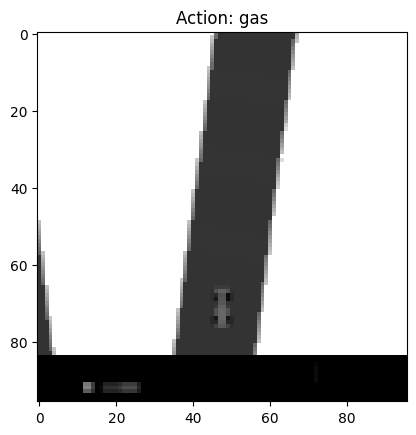

In [5]:
X = np.concatenate((X_train, X_val), 0)

plt.imshow(X[j], 'gray')
plt.title(f'Action: {action_names[y[j]]}')
plt.show()

# CNNs

### Utilities

Hyperparameters and callbacks for the CNN models.

In [6]:
import plaidml.keras
plaidml.keras.install_backend()
from keras.callbacks import Callback
# from keras.utils import Sequence

# class NoisyDataGenerator(Sequence):
#     def __init__(self, X_train, y_train, batch_size=64, noise=0.1):
#         self.X_train = X_train
#         self.y_train = y_train
#         self.batch_size = batch_size
#         self.noise = noise

#     def __len__(self):
#         return int(np.ceil(self.y_train.shape[0]/self.batch_size))

#     def __getitem__(self, index):
#         start_idx = index*self.batch_size
#         end_idx = (index+1)*self.batch_size

#         batch_X = self.X_train[start_idx:end_idx]
#         batch_y = np.copy(self.y_train[start_idx:end_idx])

#         num_classes = np.unique(self.y_train).shape[0]
#         num_modifications = int(self.noise*batch_y.shape[0])
#         indices_to_modify = np.random.choice(batch_y.shape[0], num_modifications, replace=False)

#         batch_y.flat[indices_to_modify] = np.random.randint(0, num_classes, size=num_modifications)

#         return batch_X, batch_y

# train_gen = NoisyDataGenerator(X_train, y_train, batch_size=batch_size)


class MyEarlyStopping(Callback):
    def __init__(self, monitor='val_loss', patience=10, start_from_epoch=0):
        super(MyEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.start_from_epoch = start_from_epoch
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None

        if 'acc' in self.monitor:
            self.monitor_op = np.greater
        else:
            self.monitor_op = np.less

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0.5
        self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None or epoch < self.start_from_epoch:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        return monitor_value


class_weight = {0: 1.2, 1: 1, 2: 1, 3: 0.7, 4: 2.2}
models = [None, None]
histories = [None, None]

epochs = 50
batch_size = 64
patience = 6

### Model 0

This model starts with large kernels in order to grasp the general features of the observations, which become smaller in order to focus on the details in the next layer.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Activation
from keras.regularizers import l2

input_shape = X_train.shape[1:]

# model structure
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=7, strides=3,
          input_shape=input_shape, kernel_regularizer=l2(1e-3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=16, kernel_size=4, kernel_regularizer=l2(1e-3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, kernel_regularizer=l2(1e-3)))
model.add(Dropout(0.4))
model.add(Activation('relu'))

model.add(Dense(64, kernel_regularizer=l2(1e-3)))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(len(actions), activation='softmax'))
# end model structure

model.compile('nadam', 'sparse_categorical_crossentropy',
              ['accuracy'], weighted_metrics=['accuracy'])
model.summary()

models[0] = model

INFO:plaidml:Opening device "opencl_intel_iris(r)_xe_graphics.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 8)         400       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        2064      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

Fitting model 0.

In [33]:
early_stopping = MyEarlyStopping(patience=patience, start_from_epoch=20)

# histories[0] = models[0].fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(
#     train_gen), validation_data=(X_val, y_val), callbacks=[early_stopping])
histories[0] = models[0].fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(
    X_val, y_val), callbacks=[early_stopping], class_weight=class_weight)

Train on 6369 samples, validate on 2749 samples
Epoch 1/50
6369/6369 [==============================] - 12s 2ms/step - loss: 1.5917 - acc: 0.4539 - weighted_acc: 0.4231 - val_loss: 1.3730 - val_acc: 0.5915 - val_weighted_acc: 0.5915
Epoch 2/50
6369/6369 [==============================] - 4s 655us/step - loss: 1.4294 - acc: 0.5233 - weighted_acc: 0.4790 - val_loss: 1.3440 - val_acc: 0.5813 - val_weighted_acc: 0.5813
Epoch 3/50
6369/6369 [==============================] - 4s 665us/step - loss: 1.3715 - acc: 0.5585 - weighted_acc: 0.5100 - val_loss: 1.3016 - val_acc: 0.6097 - val_weighted_acc: 0.6097
Epoch 4/50
6369/6369 [==============================] - 4s 659us/step - loss: 1.3333 - acc: 0.5715 - weighted_acc: 0.5230 - val_loss: 1.2350 - val_acc: 0.6566 - val_weighted_acc: 0.6566
Epoch 5/50
6369/6369 [==============================] - 4s 684us/step - loss: 1.3087 - acc: 0.5762 - weighted_acc: 0.5308 - val_loss: 1.2627 - val_acc: 0.6675 - val_weighted_acc: 0.6675
Epoch 6/50
6369/6369 [=

In [34]:
model_path = './models/'
os.makedirs(model_path, exist_ok=True)

models[0].save(model_path+'model-0.h5')

In [8]:
from keras.models import load_model

models[0].load_weights(model_path+'model-0.h5')

NameError: name 'model_path' is not defined

### Model 1

The opposite strategy must be explored as well, with small filters that become larger in the second layer.

In [ ]:
# model structure
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=3, strides=2,
          input_shape=input_shape, kernel_regularizer=l2(1e-3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=12, kernel_size=5, kernel_regularizer=l2(1e-3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, kernel_regularizer=l2(1e-3)))
model.add(Dropout(0.4))
model.add(Activation('relu'))

model.add(Dense(len(actions), activation='softmax'))
# end model structure

model.compile('adam', 'sparse_categorical_crossentropy', [
              'accuracy'], weighted_metrics=['accuracy'])
model.summary()

models[1] = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 47, 47, 6)         60        
_________________________________________________________________
activation_5 (Activation)    (None, 47, 47, 6)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 12)        1812      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 12)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 12)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
__________

Fitting model 1.

In [37]:
early_stopping = MyEarlyStopping(patience=patience, start_from_epoch=20)

# histories[1] = models[1].fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(
#     train_gen), validation_data=(X_val, y_val), callbacks=[early_stopping])
histories[1] = models[1].fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(
    X_val, y_val), callbacks=[early_stopping], class_weight=class_weight)

Train on 6369 samples, validate on 2749 samples
Epoch 1/50
6369/6369 [==============================] - 16s 2ms/step - loss: 1.5735 - acc: 0.4660 - weighted_acc: 0.4324 - val_loss: 1.2749 - val_acc: 0.6013 - val_weighted_acc: 0.6013
Epoch 2/50
6369/6369 [==============================] - 8s 1ms/step - loss: 1.3779 - acc: 0.5437 - weighted_acc: 0.4951 - val_loss: 1.3363 - val_acc: 0.5937 - val_weighted_acc: 0.5937
Epoch 3/50
6369/6369 [==============================] - 8s 1ms/step - loss: 1.3331 - acc: 0.5657 - weighted_acc: 0.5126 - val_loss: 1.3081 - val_acc: 0.6042 - val_weighted_acc: 0.6042
Epoch 4/50
6369/6369 [==============================] - 8s 1ms/step - loss: 1.3035 - acc: 0.5751 - weighted_acc: 0.5239 - val_loss: 1.3222 - val_acc: 0.6097 - val_weighted_acc: 0.6097
Epoch 5/50
6369/6369 [==============================] - 8s 1ms/step - loss: 1.2868 - acc: 0.5805 - weighted_acc: 0.5297 - val_loss: 1.2763 - val_acc: 0.6264 - val_weighted_acc: 0.6264
Epoch 6/50
6369/6369 [=========

In [38]:
models[1].save(model_path+'model-1.h5')

In [ ]:
models[1].load_weights(model_path+'model-1.h5')

# Results

### Validation loss and accuracy vs. epochs

Here are the validation loss and accuracy plot per epoch.

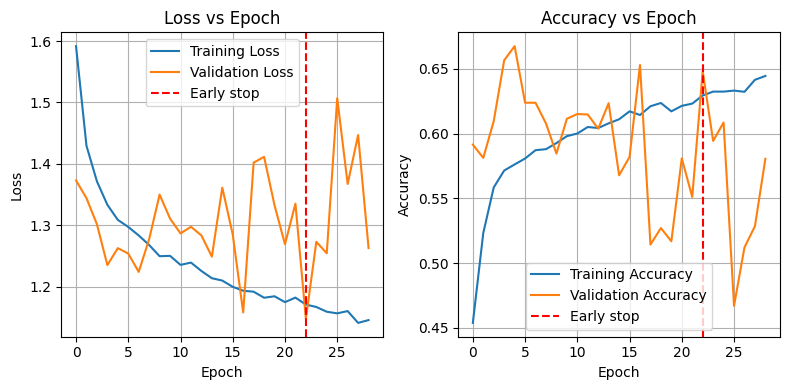

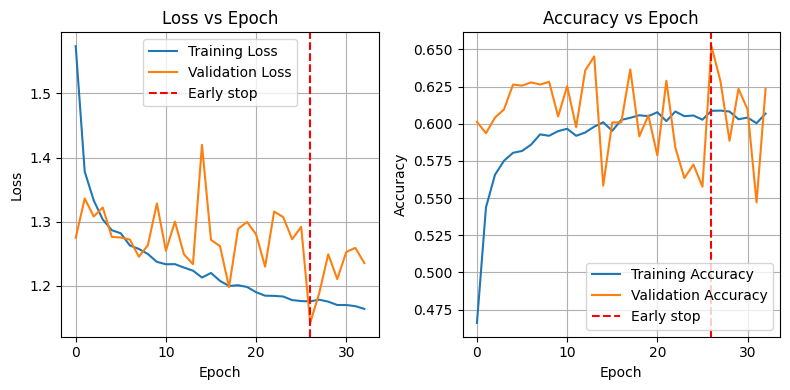

In [ ]:
def plot_loss_accuracy(history):
    early_stop = len(history.history['loss'])-patience-1

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axvline(early_stop, color='red', linestyle='--', label='Early stop')
    plt.title('Loss vs. epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.axvline(early_stop, color='red', linestyle='--', label='Early stop')
    plt.title('Accuracy vs. epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_loss_accuracy(histories[0])
plot_loss_accuracy(histories[1])

### Classification report

In [41]:
from sklearn.metrics import classification_report

y_pred = []

y_pred.append(np.argmax(models[0].predict(X_val), 1))
print(classification_report(y_val, y_pred[0], zero_division=np.nan))

y_pred.append(np.argmax(models[1].predict(X_val), 1))
print(classification_report(y_val, y_pred[1], zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.24      0.47      0.31       133
           1       0.38      0.58      0.46       275
           2       0.52      0.68      0.59       406
           3       0.87      0.68      0.76      1896
           4       0.05      0.08      0.06        39

    accuracy                           0.65      2749
   macro avg       0.41      0.50      0.44      2749
weighted avg       0.72      0.65      0.67      2749

              precision    recall  f1-score   support

           0       0.28      0.38      0.32       133
           1       0.36      0.54      0.43       275
           2       0.49      0.65      0.56       406
           3       0.84      0.70      0.77      1896
           4       0.06      0.05      0.05        39

    accuracy                           0.65      2749
   macro avg       0.40      0.46      0.43      2749
weighted avg       0.70      0.65      0.67      2749



### Confusion matrices

<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

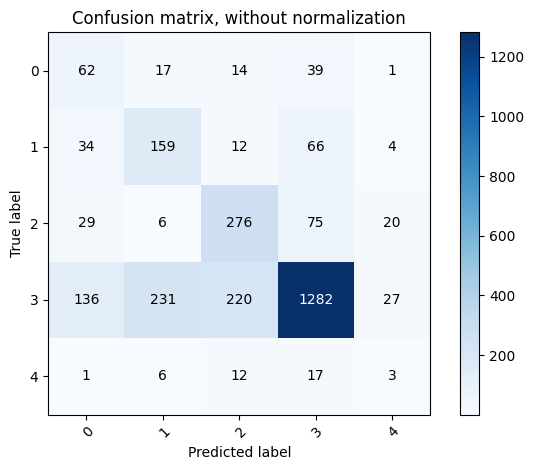

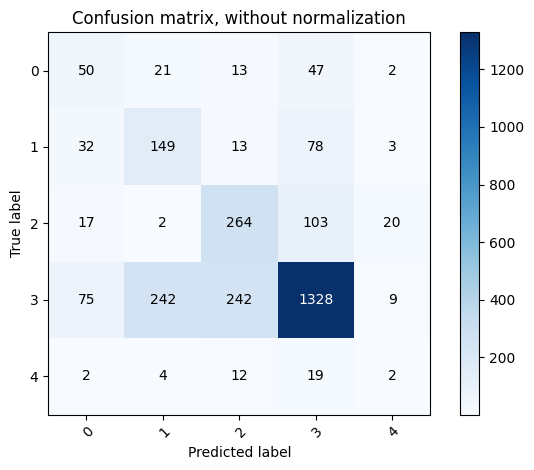

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


plot_confusion_matrix(y_val, y_pred[0], actions)

plot_confusion_matrix(y_val, y_pred[1], actions)

### Car Racing game

In this section, some videos of the CNN models playing the car racing game are taken and saved.

In [33]:
import sys
try:
    import gymnasium as gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model, seed=2000):
    obs, _ = env.reset(seed=seed)

    action0 = 0
    for i in range(50):
        obs, _, _, _, _ = env.step(action0)

    done = False
    while not done:
        obs = preprocess(obs)
        input = np.zeros((1, 96, 96, 1))
        input[0, :, :, 0] = obs

        p = model.predict(input)
        action = np.argmax(p)

        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated


env_arguments = {
    'max_episode_steps': 1500,
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'rgb_array'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Environment: CarRacing-v2
Action space: Discrete(5)
Observation space: Box(0, 255, (96, 96, 3), uint8)


In [34]:
from gymnasium.wrappers import RecordVideo
import shutil

video_path = './videos'
if os.path.exists(video_path):
    shutil.rmtree(video_path)

envs = []
seeds = [7312579, 5209049, 4490388, 939473,
         110226, 3485719, 3587923, 649834, 2223419]

for seed in seeds:
    rec_env = RecordVideo(env, video_path+'/'+str(seed),
                          name_prefix='model-0-'+str(seed))
    play(rec_env, models[0], seed)

    rec_env = RecordVideo(env, video_path+'/'+str(seed),
                          name_prefix='model-1-'+str(seed))
    play(rec_env, models[1], seed)

Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\7312579\model-0-7312579-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\7312579\model-0-7312579-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\7312579 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\7312579\model-0-7312579-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\7312579\model-1-7312579-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\7312579\model-1-7312579-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\7312579\model-1-7312579-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\5209049\model-0-5209049-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\5209049\model-0-5209049-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\5209049\model-0-5209049-episode-0.mp4


c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\5209049 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\5209049\model-1-5209049-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\5209049\model-1-5209049-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\5209049\model-1-5209049-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\4490388\model-0-4490388-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\4490388\model-0-4490388-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\4490388 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\4490388\model-0-4490388-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\4490388\model-1-4490388-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\4490388\model-1-4490388-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\4490388\model-1-4490388-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\939473\model-0-939473-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\939473\model-0-939473-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\939473 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\939473\model-0-939473-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\939473\model-1-939473-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\939473\model-1-939473-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\939473\model-1-939473-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\110226\model-0-110226-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\110226\model-0-110226-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\110226 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\110226\model-0-110226-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\110226\model-1-110226-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\110226\model-1-110226-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\110226\model-1-110226-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\3485719\model-0-3485719-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\3485719\model-0-3485719-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\3485719 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\3485719\model-0-3485719-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\3485719\model-1-3485719-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\3485719\model-1-3485719-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\3485719\model-1-3485719-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\3587923\model-0-3587923-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\3587923\model-0-3587923-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\3587923 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\3587923\model-0-3587923-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\3587923\model-1-3587923-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\3587923\model-1-3587923-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\3587923\model-1-3587923-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\649834\model-0-649834-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\649834\model-0-649834-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\649834 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\649834\model-0-649834-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\649834\model-1-649834-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\649834\model-1-649834-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\649834\model-1-649834-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\2223419\model-0-2223419-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\2223419\model-0-2223419-episode-0.mp4



c:\Users\antor\anaconda3\envs\keras-gpu\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\antor\Desktop\ML_HW2\videos\2223419 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\2223419\model-0-2223419-episode-0.mp4
Moviepy - Building video c:\Users\antor\Desktop\ML_HW2\videos\2223419\model-1-2223419-episode-0.mp4.
Moviepy - Writing video c:\Users\antor\Desktop\ML_HW2\videos\2223419\model-1-2223419-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\antor\Desktop\ML_HW2\videos\2223419\model-1-2223419-episode-0.mp4


### Effect of class weights

Since both the training and validation sets are unbalanced (moreover, in a different way) choosing the right class weights is crucial in order to determine the behavior and the performance of the CNN. Consider the following weight configurations:
- no weights;
- weights automatically computed in order to balance the training set;
- weights equal to the validation set over training set class sizes ratio;
- 4 configurations of manually selected weights;

In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = []

class_weights.append(None)

class_weight = dict(enumerate(compute_class_weight(
    'balanced', classes=actions, y=y_train)))
class_weights.append(class_weight)

class_weight = {}
for i, value in enumerate(np.bincount(y_val)/np.bincount(y_train)):
    class_weight[i] = value
class_weights.append(class_weight)

class_weight = {0: 1.2, 1: 1, 2: 1, 3: 0.7, 4: 2.2}
class_weights.append(class_weight)

class_weight = {0: 0.9, 1: 1, 2: 1, 3: 0.8, 4: 1.8}
class_weights.append(class_weight)

class_weight = {0: 1, 1: 1, 2: 1, 3: 0.2, 4: 2}
class_weights.append(class_weight)

class_weight = {0: 0.6, 1: 0.7, 2: 0.7, 3: 0.4, 4: 2}
class_weights.append(class_weight)

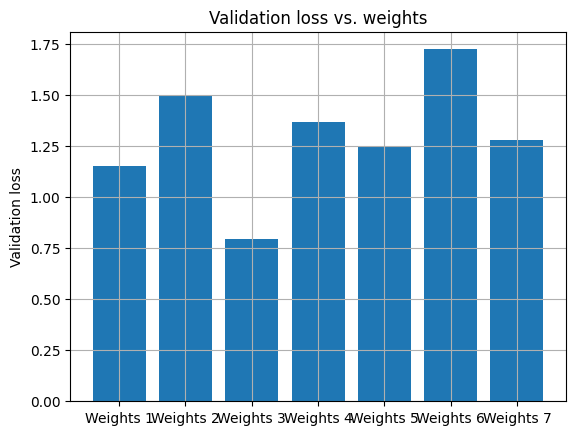

<Figure size 640x480 with 0 Axes>

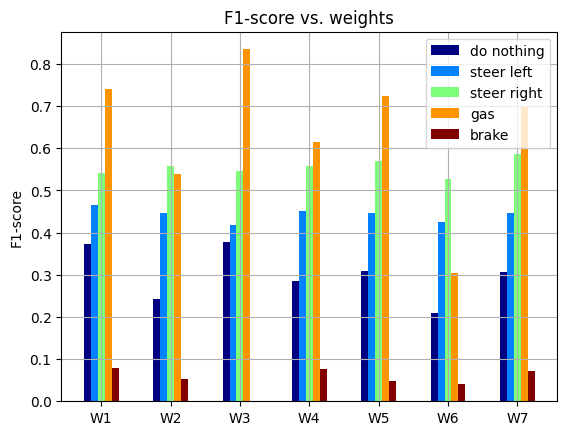

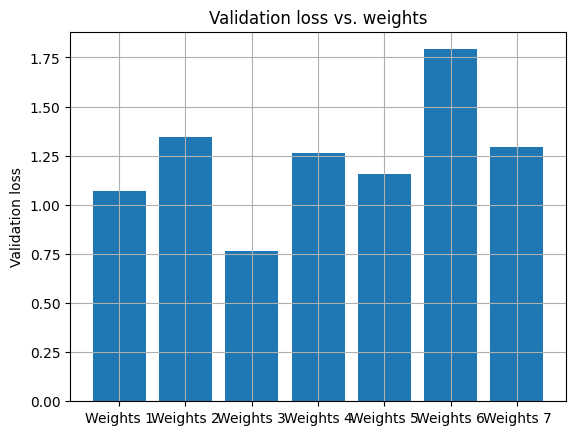

<Figure size 640x480 with 0 Axes>

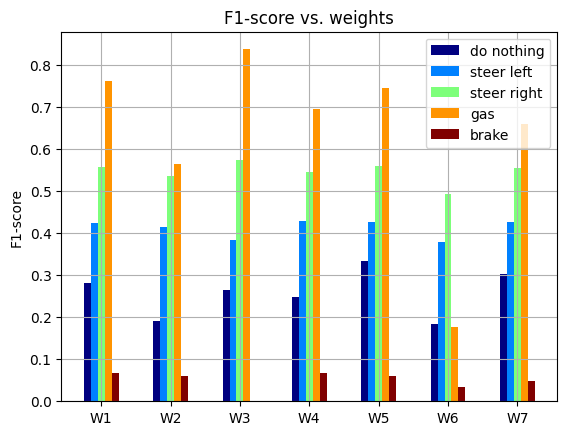

In [44]:
from sklearn.metrics import f1_score

def weight_eval(model):
    Wsave = model.get_weights()
    weight_eval_result = {'class_weights': [],
                          'validation_loss': [], 'f1_scores': []}

    for class_weight in class_weights:
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(
            X_val, y_val), callbacks=[early_stopping], class_weight=class_weight, verbose=0)

        early_stop = len(history.history['val_loss'])-patience-1
        val_loss = history.history['val_loss'][early_stop]

        y_pred = np.argmax(model.predict(X_val), 1)
        f1_scores = f1_score(y_val, y_pred, average=None)

        weight_eval_result['class_weights'].append(class_weight)
        weight_eval_result['validation_loss'].append(val_loss)
        weight_eval_result['f1_scores'].append(f1_scores)

        model.set_weights(Wsave)

    return weight_eval_result


def plot_weight_eval_result(weight_eval_result):
    val_loss = np.array(weight_eval_result['validation_loss'])

    plt.figure()
    plt.bar(range(val_loss.shape[0]), val_loss)
    plt.ylabel('Validation loss')
    plt.title('Validation loss vs. weights')
    plt.xticks(range(val_loss.shape[0]), [
               f'W{i + 1}' for i in range(val_loss.shape[0])])
    plt.grid()
    plt.show()

    f1_scores = np.array(weight_eval_result['f1_scores'])

    plt.figure()
    _, ax = plt.subplots()
    ax.grid()
    bar_width = 0.1
    bar_positions = np.arange(len(f1_scores))

    for i in range(len(f1_scores[0])):
        ax.bar(bar_positions+i*bar_width,
               f1_scores[:, i], width=bar_width, label=action_names[i], color=colors[i])

    ax.set_ylabel('F1-score')
    ax.set_title('F1-score vs. weights')
    ax.set_xticks(bar_positions+(len(f1_scores[0])-1)*bar_width/2)
    ax.set_xticklabels([f'W{i + 1}' for i in range(f1_scores.shape[0])])
    ax.legend()
    plt.show()

weight_eval_results = []

weight_eval_results.append(weight_eval(models[0]))
plot_weight_eval_result(weight_eval_results[0])

weight_eval_results.append(weight_eval(models[1]))
plot_weight_eval_result(weight_eval_results[1])